In [2]:
import os
import io
import json
import requests
import numpy as np
import pandas as pd

# Fetching Data

In [3]:
project_dir = os.path.split(os.getcwd())[0]
path_to_data = os.path.join(project_dir, 'data')

In [4]:
# Loading API keys
path_to_keys = os.path.join(project_dir, 'api_keys.json')
with open(path_to_keys, 'r') as f:
    api_keys = json.load(f)

In [5]:
ticker = 'INTC'
CIK = '0000050863'

## Fetching stock price data

In [6]:
# Stock price url and params
# url = 'https://www.quandl.com/api/v3/datasets/EOD/INTC.csv'
aa_url = 'https://www.alphavantage.co/query'
aa_params = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': ticker, 'datatype': 'csv',
             'apikey': api_keys['alphavantage'], 'outputsize': 'full'}


In [7]:
# Accessing data
aa_response = requests.get(aa_url, params=aa_params)
with open(os.path.join(path_to_data, 'raw_TS_prices.csv'), 'w') as f:
    f.write(aa_response.text)

In [8]:
# inspecting data
price_df = pd.read_csv(os.path.join(path_to_data, 'raw_TS_prices.csv'), parse_dates=['timestamp'])
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null int64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 354.0 KB


In [9]:
price_df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-09-19,51.70,51.98,51.500,51.58,51.58,7337207,0.0,1.0
1,2019-09-18,52.13,52.10,51.162,51.74,51.74,13034209,0.0,1.0
2,2019-09-17,52.05,52.14,51.350,51.95,51.95,19641100,0.0,1.0
3,2019-09-16,51.90,52.29,51.700,52.20,52.20,13354600,0.0,1.0
4,2019-09-13,52.76,53.00,52.230,52.54,52.54,18010800,0.0,1.0


In [10]:
# data need from time series to fetch text data
start_date = price_df.timestamp.min()
print(start_date)

1999-09-20 00:00:00


## Fetching text data

In [75]:
import re
import datetime
import lxml
from bs4 import BeautifulSoup

In [76]:
edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
edgar_params = {'action': 'getcompany', 'CIK': CIK, 'type': '8-k',
                'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}

In [77]:
edgar_response = requests.get(edgar_url, params=edgar_params)
print(edgar_response.url)

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000050863&type=8-k&owner=exclude&count=100&output=atom&start=


In [78]:
# Parsing initial response to build list of document urls and filing dates

soup = BeautifulSoup(edgar_response.text, 'lxml')

all_docs = []
# While the link to the next page existing is true
while True:
    # Find all document entries on the page
    entries = soup.find_all('entry')
    # For each entry scrape the filing-date and the url to the text document
    for entry in entries:
        filing_date = entry.find('filing-date').text
        doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
        doc_entry = (filing_date, doc_link)
        all_docs.append(doc_entry)
    # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
    if soup.find_all('link', {'rel': 'next'}) == []:
        break
    # Find link to the next page, request next page, and update soup object to consist of the next page
    nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
    nxt_pg = requests.get(nxt_pg_link)
    soup = BeautifulSoup(nxt_pg.text, 'lxml')

In [79]:
doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
filing_date    335 non-null datetime64[ns]
doc_loc        335 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 5.4+ KB


In [80]:
doc_df.head()

,filing_date,doc_loc
0,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...
1,2019-07-25,https://www.sec.gov/Archives/edgar/data/50863/...
2,2019-05-22,https://www.sec.gov/Archives/edgar/data/50863/...
3,2019-05-09,https://www.sec.gov/Archives/edgar/data/50863/...
4,2019-04-25,https://www.sec.gov/Archives/edgar/data/50863/...


## Combining dataframes and saving date to disk

In [95]:
# Helper Functions

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    r = requests.get(url)
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'w') as f:
        f.write(r.text)
    return os.path.join(endpoint, fname)

### Merging dataframes

In [96]:
df = price_df.merge(doc_df, how='outer', left_on='timestamp', right_on='filing_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5059 entries, 0 to 5058
Data columns (total 11 columns):
timestamp            5043 non-null datetime64[ns]
open                 5043 non-null float64
high                 5043 non-null float64
low                  5043 non-null float64
close                5043 non-null float64
adjusted_close       5043 non-null float64
volume               5043 non-null float64
dividend_amount      5043 non-null float64
split_coefficient    5043 non-null float64
filing_date          335 non-null datetime64[ns]
doc_loc              335 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 474.3+ KB


In [97]:
df.head(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
0,2019-09-19,51.70,51.98,51.500,51.58,51.58,7337207.0,0.0,1.0,NaT,NaN
1,2019-09-18,52.13,52.10,51.162,51.74,51.74,13034209.0,0.0,1.0,NaT,NaN
2,2019-09-17,52.05,52.14,51.350,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN
3,2019-09-16,51.90,52.29,51.700,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN
4,2019-09-13,52.76,53.00,52.230,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...
5,2019-09-12,53.00,53.33,52.070,53.01,53.01,23308700.0,0.0,1.0,NaT,NaN
6,2019-09-11,51.60,52.79,51.380,52.79,52.79,18968900.0,0.0,1.0,NaT,NaN
7,2019-09-10,51.33,51.84,50.830,51.82,51.82,18532000.0,0.0,1.0,NaT,NaN
8,2019-09-09,51.06,52.03,51.020,51.59,51.59,20749700.0,0.0,1.0,NaT,NaN
9,2019-09-06,50.25,50.99,50.070,50.92,50.92,17067900.0,0.0,1.0,NaT,NaN


In [98]:
df.tail(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
5039,1999-09-23,41.563,41.594,38.250,38.750,25.0824,73686000.0,0.0,1.0,NaT,NaN
5040,1999-09-22,41.156,41.844,40.688,41.406,26.8017,42055400.0,0.0,1.0,NaT,NaN
5041,1999-09-21,41.875,41.875,40.969,41.000,26.5387,38608600.0,0.0,1.0,NaT,NaN
5042,1999-09-20,42.344,42.813,41.781,42.031,27.2063,20707200.0,0.0,1.0,NaT,NaN
5043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-21,https://www.sec.gov/Archives/edgar/data/50863/...
5044,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-08-10,https://www.sec.gov/Archives/edgar/data/50863/...
5045,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-14,https://www.sec.gov/Archives/edgar/data/50863/...
5046,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-08,https://www.sec.gov/Archives/edgar/data/50863/...
5047,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-14,https://www.sec.gov/Archives/edgar/data/50863/...
5048,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-03-12,https://www.sec.gov/Archives/edgar/data/50863/...


### Saving data to disk

In [99]:
# Downloading and saving SEC files to disk and modifying doc_loc
df['doc_loc'] = df['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_data, 'documents')) if not pd.isnull(url) else np.nan)
df.head(10)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
0,2019-09-19,51.70,51.98,51.500,51.58,51.58,7337207.0,0.0,1.0,NaT,NaN
1,2019-09-18,52.13,52.10,51.162,51.74,51.74,13034209.0,0.0,1.0,NaT,NaN
2,2019-09-17,52.05,52.14,51.350,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN
3,2019-09-16,51.90,52.29,51.700,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN
4,2019-09-13,52.76,53.00,52.230,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,/media/Data/Programs/FinTech/data/documents/00...
5,2019-09-12,53.00,53.33,52.070,53.01,53.01,23308700.0,0.0,1.0,NaT,NaN
6,2019-09-11,51.60,52.79,51.380,52.79,52.79,18968900.0,0.0,1.0,NaT,NaN
7,2019-09-10,51.33,51.84,50.830,51.82,51.82,18532000.0,0.0,1.0,NaT,NaN
8,2019-09-09,51.06,52.03,51.020,51.59,51.59,20749700.0,0.0,1.0,NaT,NaN
9,2019-09-06,50.25,50.99,50.070,50.92,50.92,17067900.0,0.0,1.0,NaT,NaN


In [107]:
# Saving modified dataframe to disk
df.to_csv(os.path.join(path_to_data, 'raw.csv'), index=False)

## Exploratory Data Analysis

In [185]:
import matplotlib.pyplot as plt

In [186]:
# Helper Functions

def plot_col(col, title, xl, yl):
    xy = df[col].dropna()
    xy.index = len(xy.index) - 1 - xy.index
    fig, ax = plt.subplots()
    ax.plot(xy.index, xy[xy.index])
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    return None

see if there is any correlation between the release date of an 8k form and change in yield

In [196]:
# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp', 'filing_date'])
df.index = list(df.index)
df.index = len(df.index) - 1 - df.index
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5059 entries, 5058 to 0
Data columns (total 11 columns):
timestamp            5043 non-null datetime64[ns]
open                 5043 non-null float64
high                 5043 non-null float64
low                  5043 non-null float64
close                5043 non-null float64
adjusted_close       5043 non-null float64
volume               5043 non-null float64
dividend_amount      5043 non-null float64
split_coefficient    5043 non-null float64
filing_date          335 non-null datetime64[ns]
doc_loc              335 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 474.3+ KB


In [193]:
df.describe()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5.043000e+03,5043.000000,5043.000000
mean,29.129271,29.519814,28.743246,29.125820,22.894751,4.969951e+07,0.002394,1.000198
std,11.206534,11.395813,11.031365,11.206902,10.910996,2.625561e+07,0.022497,0.014082
min,12.170000,12.630000,12.050000,12.080000,8.615100,1.155400e+06,0.000000,1.000000
25%,21.220000,21.450000,21.004450,21.210000,15.253600,2.968790e+07,0.000000,1.000000
50%,25.850000,26.140000,25.570000,25.880000,18.702400,4.709750e+07,0.000000,1.000000
75%,34.190000,34.548500,33.750000,34.205000,28.956100,6.312485e+07,0.000000,1.000000
max,75.625000,75.828000,73.625000,74.875000,58.069900,3.093476e+08,0.315000,2.000000


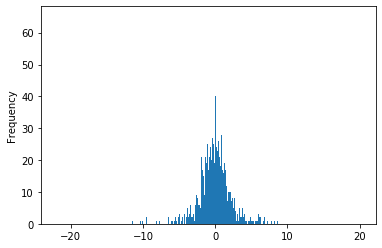

In [214]:
df['daily_returns'] = ((df['adjusted_close'].shift(1) - df['adjusted_close']) / df['adjusted_close']) * 100
df['daily_returns'].dropna().plot.hist(bins=2000)
# appears normally distributed?

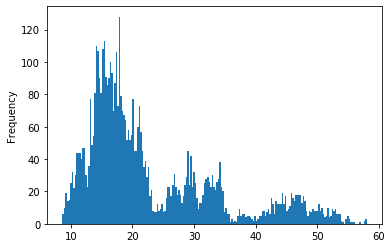

In [218]:
df.adjusted_close.dropna().plot.hist(bins=200) # lognormal

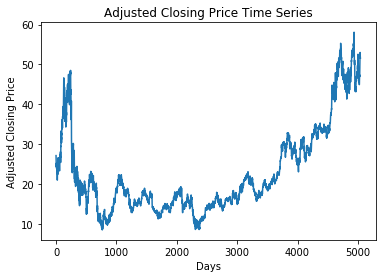

In [181]:
plot_col('adjusted_close', 'Adjusted Closing Price Time Series', 'Days', 'Adjusted Closing Price')

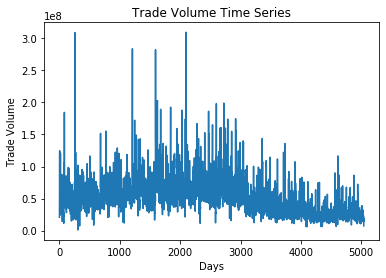

In [183]:
plot_col('volume', 'Trade Volume Time Series', 'Days', 'Trade Volume')

In [ ]:
xy = df.volume.dropna()
xy.index = len(xy.index) - 1 - xy.index
plt.plot(xy.index, xy[xy.index])
plt.title('Adjusted Closing Price Time Series')
plt.xlabel('Days')
plt.ylabel('Adjusted Closing Price')
plt.show()

In [129]:
## Extrainous but maybe usefull code
"""
# EDGAR url and params
edgar_url = 'https://www.sec.gov/Archives/edgar/full-index/'
edgar_start_yr = start_date.year
edgar_start_qtr = ((start_date.month - 1) // (12 // 4)) + 1
edgar_current_yr = datetime.datetime.now().year
edgar_current_qtr = ((datetime.datetime.now().month - 1) // (12 // 4)) + 1

for yr in range(edgar_start_yr, edgar_current_yr + 1):
    for qtr in range(1, 5):
        if not (((yr == edgar_start_yr) and (qtr < edgar_start_qtr))
                or ((yr == edgar_current_yr) and (qtr > edgar_current_qtr))):
            url = edgar_url + str(yr) + '/QTR' + str(qtr) + '/master.idx'


"""

"\n# EDGAR url and params\nedgar_url = 'https://www.sec.gov/Archives/edgar/full-index/'\nedgar_start_yr = start_date.year\nedgar_start_qtr = ((start_date.month - 1) // (12 // 4)) + 1\nedgar_current_yr = datetime.datetime.now().year\nedgar_current_qtr = ((datetime.datetime.now().month - 1) // (12 // 4)) + 1\n\nfor yr in range(edgar_start_yr, edgar_current_yr + 1):\n    for qtr in range(1, 5):\n        if not (((yr == edgar_start_yr) and (qtr < edgar_start_qtr))\n                or ((yr == edgar_current_yr) and (qtr > edgar_current_qtr))):\n            url = edgar_url + str(yr) + '/QTR' + str(qtr) + '/master.idx'\n\n\n"